# Extended KNN, SVM: Probability of death

### Juan Felipe Godoy

### 1. Intial Setup

In [138]:
# Import packages

%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
from math import floor, ceil
import random
import time
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
!pip install imblearn

In [4]:
# Working directory
import os
os.getcwd()
#os.chdir("C:/Users/acer/Dropbox/BGSE/Term-1/Computational_Machine_Learning/KNN-extended-project")

'C:\\Users\\acer\\Dropbox\\BGSE\\Term-1\\Computational_Machine_Learning\\KNN-extended-project'

### 2. Utils and functions

In [208]:
# 1. Drops columns
def delete_columns(dataset, columns):
  dataset = dataset.drop(columns, axis=1)
  return dataset

# 2. Creates dummmies from categorical variables
def categorical_dummies(dataset, columns):
  dataset = pd.get_dummies(dataset, columns=columns, drop_first=True)
  return dataset

# 3. Returns a vector of all columns with the sum of nulls
def column_sum_nulls(dataset):
  return dataset.isnull().sum()


#4. Replace null values from a numerical column for the mean of the column
def nulls_mean(dataset, columns):
   We instantiate the imputer
  imr = SimpleImputer(missing_values=np.nan, strategy='mean')
  imr = imr.fit(dataset[columns])
  dataset[columns] = imr.transform(dataset[columns])
  return dataset

#5. IterativeImputer
def replace_nulls_iteratively(dataset, columns):
    iimpr = IterativeImputer(missing_values=np.nan)
    iimpr = iimp.fit(dataset[columns])
    dataset[columns] = iimr.transform(dataset[columns])
    return dataset


#6. Calculates the age when entering ICU.
def age_admitted(data, columns):
  for c in columns:
    data[c] = pd.to_datetime(data[c])

  data['AGE'] = data['ADMITTIME'].dt.year - data['DOB'].dt.year

date_columns = ['DOB', 'ADMITTIME']

### 3. Load data.

#### 3.1 Training data

In [183]:
d_train = pd.read_csv("mimic_train.csv")
print(d_train.shape)
pd.set_option("display.max_columns", None)
d_train.head()

(20885, 44)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


#### Y train.

In [184]:
y_train = d_train['HOSPITAL_EXPIRE_FLAG']

#### 3.2 Test data

In [185]:
d_test = pd.read_csv("mimic_test_death.csv")
print(d_test.shape)
pd.set_option("display.max_columns", None)
d_test.head()

(5221, 39)


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,53.0,102.0,68.200000,6.0,24.0,12.294118,35.300000,38.200000,37.405149,95.0,100.0,99.191489,89.0,230.0,134.684211,M,2114-08-07 00:00:00,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,50.0,276.0,85.000000,20.0,40.0,26.097561,36.055556,39.444444,37.833333,93.0,100.0,97.666667,152.0,1016.0,391.526316,M,2055-06-04 00:00:00,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,60.0,87.0,77.346154,16.0,27.0,22.071429,37.166667,39.166667,38.380342,92.0,100.0,95.888889,100.0,149.0,123.000000,M,2073-04-21 00:00:00,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,46.0,110.0,78.500000,10.0,26.0,14.000000,35.944444,37.777778,36.928105,89.0,100.0,95.272727,130.0,177.0,147.250000,F,2078-04-14 00:00:00,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,66.0,135.0,86.416667,7.0,29.0,24.161290,36.111111,37.277778,36.642857,86.0,100.0,96.000000,74.0,248.0,155.500000,F,2050-01-17 00:00:00,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU


### 4. New variables. 

Given that the objective of the task is to predict the probability of death among patients, a good initial approximation is to explore the pathologies suffered by the people who actually died. 

#### 4.1 Most frequent diagnosis among dead people.

The first additional variable I include is the relative frequency of ICD9 diagnosis among people who died. To calculate this variable, I selected from the training data only the observations that have HOSPITAL_EXPIRE_FLAG == 1 and count their occurrences in the table. 
With this variable I can identify the main cause/diseases associated to the entrances of patients and their relative weight on people how died. Higher frequency of disease 'i' tells us that, among the people how died, many patients suffer from it.

In [186]:
# Filter dead patients in train
letal_dis = d_train[d_train['HOSPITAL_EXPIRE_FLAG']==1]
letal_dis = letal_dis[['subject_id', 'ICD9_diagnosis']]

## Count frequency of letal diseases
letal_dis = letal_dis.groupby(['ICD9_diagnosis'])['subject_id'].nunique().reset_index()
letal_dis.rename(columns={'subject_id': 'occurr'}, inplace=True)

# Calculate the relative frequency.
letal_dis['Total'] = letal_dis['occurr'].sum()
letal_dis['Freq'] = (letal_dis['occurr']/letal_dis['Total'])*100
letal_dis = letal_dis[['ICD9_diagnosis','occurr', 'Freq']]
letal_dis.sort_values('Freq', ascending =False)

,ICD9_diagnosis,occurr,Freq
16,0389,271,12.947922
191,431,129,6.163402
258,51881,87,4.156713
190,430,47,2.245581
236,486,41,1.958911
...,...,...,...
86,20190,1,0.047778
275,53250,1,0.047778
276,53260,1,0.047778
277,53541,1,0.047778


From the table above we can see that the most frequent diagnosis is 0389 (Septicemia) followed by 431(Intracerebral hemorrhage), 51881(Acute respiratory failure) and 430(Subarachnoid hemorrhage). 

In [187]:
## Merge the letal_dis data frame with d_train 
d_train = d_train.merge(letal_dis, on='ICD9_diagnosis', how='left')
d_train.head()
print(d_train.shape)

(20885, 46)


In [188]:
## Merge the letal_dis data frame with d_test
d_test = d_test.merge(letal_dis, on='ICD9_diagnosis', how='left')
d_test.head()
print(d_test.shape)

(5221, 41)


#### 4.2 Most common comorbidities among dead people.

Although the main diagnosis is useful to understand a patient condition in ICU, it is also relevant to explore if the person has had other comorbidities which could affect her risk of surviving. 

Therefore, using the MIMIC_diagnoses data set, I identify the top 30 comorbidities suffered by patients that actually died. 

In this case I build dummy variables for each of the top 30 most frequent comorbidities that each patient (subject_it) suffered additionally to the main diagnosis.

In [189]:
# Import data set
d_comob = pd.read_csv("extra_data/MIMIC_diagnoses.csv")
print(d_comob.shape)
pd.set_option("display.max_columns", None)
d_comob.rename(columns={'SUBJECT_ID': 'subject_id', 'ICD9_CODE': 'ICD9_diagnosis'}, inplace=True)


(651047, 4)


In [190]:
# Obtain commorbidities of pople who died

# Find only people who died in trainig data
died = d_train[d_train['HOSPITAL_EXPIRE_FLAG']==1]
died = died[['subject_id', 'HOSPITAL_EXPIRE_FLAG']]

# Merge with comorbidities in order to find other diseases of dead persons
d_com_dead = pd.merge(d_comob, died, on='subject_id')
d_com_dead.head(100)

# See which comorbidity is the most frequent among dead people
d_com_dead = d_com_dead.groupby(['ICD9_diagnosis'])['subject_id'].nunique().reset_index()
d_com_dead.rename(columns={'subject_id': 'number_cases'}, inplace=True)
d_com_dead.sort_values('number_cases', ascending=False).reset_index()


,index,ICD9_diagnosis,number_cases
0,1235,51881,987
1,843,4019,967
2,1496,5849,847
3,927,42731,786
4,937,4280,703
...,...,...,...
2791,1507,5888,1
2792,1504,586,1
2793,1488,58289,1
2794,1484,5810,1


In [191]:
# Sort by number of cases and keep top 30
top_ICD9 = d_com_dead.sort_values('number_cases', ascending=False).reset_index()
top_ICD9 = top_ICD9.head(30)
top_ICD9

,index,ICD9_diagnosis,number_cases
0,1235,51881,987
1,843,4019,967
2,1496,5849,847
3,927,42731,786
4,937,4280,703
5,2316,99592,681
6,433,2762,612
7,31,0389,574
8,407,2724,518
9,1889,78552,495


In [192]:
# Select Top
top=(d_com_dead['number_cases'].sum()/top_ICD9['number_cases'].sum())*100
top

333.303267883161

I selected the top 30 comorbidities because it represents allmost 1/3 th of the number of cases. 

In [193]:
# Create a categorical variable that contains the selected comorbidities
top_ICD9['Letal_disease'] = top_ICD9['ICD9_diagnosis']
top_ICD9 = top_ICD9[['ICD9_diagnosis', 'Letal_disease']]

In [194]:
# Merge the variable with trainig data
d_train = d_train.merge(top_ICD9, on='ICD9_diagnosis', how='left')

# Replace Nan values in Letal_disease
d_train['Letal_disease'] = d_train['Letal_disease'].fillna('Other')


In [195]:
# Merge the variable with trainig data
d_test = d_test.merge(top_ICD9, on='ICD9_diagnosis', how='left')
# Replace Nan values in Letal_disease
d_test['Letal_disease'] = d_test['Letal_disease'].fillna('Other')

### 5. Clean data sets.

#### 5.1. Defining useless variables

This are variables that I am going to remove during the cleaning of the data sets and training of the models. Some of them don't provide useful information and others couldn't be known the first day a patient enters the ICU.


In [196]:
useless_var = ['subject_id','hadm_id', 'icustay_id', 'DOD', 'DEATHTIME', 'DISCHTIME', 'MARITAL_STATUS', "Diff", "DOB", "ADMITTIME", 'ICD9_diagnosis', 'DIAGNOSIS', 'ETHNICITY', 'RELIGION','HOSPITAL_EXPIRE_FLAG','LOS']
useless_var_test = ['subject_id','hadm_id', 'icustay_id', 'MARITAL_STATUS', "Diff", "DOB", "ADMITTIME", 'ICD9_diagnosis', 'DIAGNOSIS', 'ETHNICITY', 'RELIGION']

#### 5.2 Selecting all numerical variables

In [197]:
numerical_var = ['HeartRate_Min','HeartRate_Max','HeartRate_Mean','SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'AGE', 'Freq', 'occurr']

#### 5.3 Age when admitted

The age of the patient when addmitted to ICU is also an interesting variable to take in account. Young people suffer from different pathologies than those experienced by old adults. 

In [198]:
#Calculate the age of the patient at the moment of the admission to the ICU
age_admitted(d_train, date_columns)
age_admitted(d_test, date_columns)

<AxesSubplot:>

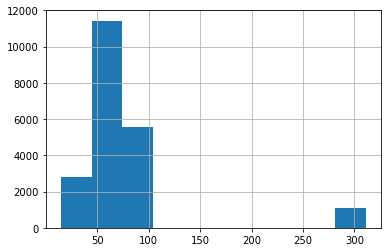

In [199]:
d_train['AGE'].hist()

<AxesSubplot:>

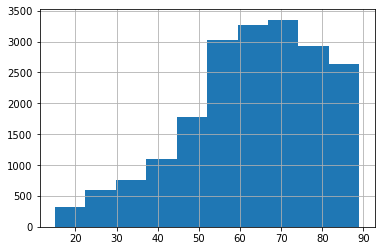

In [202]:
# Removing outliers from test and train data
d_train= d_train.drop(d_train[d_train['AGE']>=110].index)
d_test= d_test.drop(d_test[d_test['AGE']>=110].index)
d_train['AGE'].hist()

#### 5.4 Remove NaN and irrelevant variables.

In order to run our predictions, it is important to deal with the missing values. As we can see in the tables below, both our training and test sets have missing values in several variables.

In [204]:
# Count null values
column_sum_nulls(d_test)

subject_id           0
hadm_id              0
icustay_id           0
HeartRate_Min      520
HeartRate_Max      520
HeartRate_Mean     520
SysBP_Min          526
SysBP_Max          526
SysBP_Mean         526
DiasBP_Min         527
DiasBP_Max         527
DiasBP_Mean        527
MeanBP_Min         522
MeanBP_Max         522
MeanBP_Mean        522
RespRate_Min       521
RespRate_Max       521
RespRate_Mean      521
TempC_Min          612
TempC_Max          612
TempC_Mean         612
SpO2_Min           525
SpO2_Max           525
SpO2_Mean          525
Glucose_Min         47
Glucose_Max         47
Glucose_Mean        47
GENDER               0
DOB                  0
ADMITTIME            0
Diff                 0
ADMISSION_TYPE       0
INSURANCE            0
RELIGION             0
MARITAL_STATUS     176
ETHNICITY            0
DIAGNOSIS            0
ICD9_diagnosis       0
FIRST_CAREUNIT       0
occurr            1328
Freq              1328
Letal_disease        0
AGE                  0
dtype: int6

In [205]:
column_sum_nulls(d_train)

HOSPITAL_EXPIRE_FLAG        0
subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Min            2071
HeartRate_Max            2071
HeartRate_Mean           2071
SysBP_Min                2091
SysBP_Max                2091
SysBP_Mean               2091
DiasBP_Min               2092
DiasBP_Max               2092
DiasBP_Mean              2092
MeanBP_Min               2071
MeanBP_Max               2071
MeanBP_Mean              2071
RespRate_Min             2073
RespRate_Max             2073
RespRate_Mean            2073
TempC_Min                2378
TempC_Max                2378
TempC_Mean               2378
SpO2_Min                 2086
SpO2_Max                 2086
SpO2_Mean                2086
Glucose_Min               222
Glucose_Max               222
Glucose_Mean              222
GENDER                      0
DOB                         0
DOD                     13091
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME 

To solve this issue, I implemented sklearn's SimpleImputer and replace null values for the mean of the variable. This method is effective if assuming that missing values were generated at random. In other words, that there is not strong evidence that missing data has a specific bias. 

In [117]:
d_train=nulls_mean(d_train, numerical_var)
d_test = nulls_mean(d_test, numerical_var)

Finally I drop irrelevant variables

In [118]:
d_train = delete_columns(d_train, useless_var)
d_test = delete_columns(d_test,useless_var_test)

#### 5.5 Create categorical variables.

From the categorical variables below I create dummy variables  which hav had good effects on the prediction of the models. 

In [207]:
categorical_variables = ['ADMISSION_TYPE', 'FIRST_CAREUNIT', 'INSURANCE',
                'GENDER', 'Letal_disease']

In [209]:
d_train = categorical_dummies(d_train,categorical_variables)
d_test = categorical_dummies(d_test,categorical_variables)

#### 5.6 Scaling

Given that for the models explore in this exercise the parameters are not scale-independent, we must scale the data to mean 0 and standard deviation of 1. This is particularly important for KNN given the distance computation. 

In [121]:
X_train=d_train
X_test=d_test

In [122]:
X_train = X_train[(X_test.columns)]

In [123]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [124]:
X_train = pd.DataFrame(X_train, columns = d_test.columns)
X_test = pd.DataFrame(X_test, columns = d_test.columns)

In [100]:
X_test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,occurr,Freq,AGE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,GENDER_M,Letal_disease_2761,Letal_disease_2762,Letal_disease_2767,Letal_disease_2859,Letal_disease_4019,Letal_disease_40390,Letal_disease_41401,Letal_disease_42731,Letal_disease_4275,Letal_disease_4280,Letal_disease_486,Letal_disease_496,Letal_disease_5070,Letal_disease_51881,Letal_disease_53081,Letal_disease_5845,Letal_disease_5849,Letal_disease_5990,Letal_disease_Other
0,-0.832013,-0.769830,0.004460,-0.851089,0.100899,-1.307780,-0.384285,-0.622964,-1.007827,-0.242552,-0.194404,-0.894839,-1.751393,-0.636377,-1.837236,-1.093547,1.027555,1.153991,0.570515,0.404888,1.053583,-0.508576,0.519763,-0.093424,-0.430191,-0.430191,0.118938,-2.409848,-0.10318,2.38305,-0.839997,-0.483783,-0.380803,-0.335855,0.884478,-0.653124,-0.09683,0.880958,-0.040381,-0.022956,-0.032473,-0.009786,-0.0259,-0.022956,-0.235565,-0.092452,-0.035305,-0.053676,-0.124543,-0.011986,-0.114443,-0.139559,-0.016952,-0.04996,-0.100053,-0.06201,0.470473
1,1.513506,2.008463,2.061274,-1.092352,-0.342793,-1.135582,-0.206698,-0.129453,0.294598,-0.463518,6.471826,0.702827,2.390969,2.057127,1.952540,0.006329,2.685626,1.910184,0.284722,0.404888,0.362545,1.293265,9.053929,5.657750,-0.551566,-0.551566,-0.491779,0.414964,-0.10318,-0.41963,1.190481,-0.483783,-0.380803,-0.335855,-1.130611,1.531103,-0.09683,0.880958,-0.040381,-0.022956,-0.032473,-0.009786,-0.0259,-0.022956,-0.235565,-0.092452,-0.035305,-0.053676,-0.124543,-0.011986,-0.114443,-0.139559,-0.016952,-0.04996,-0.100053,-0.06201,0.470473
2,2.579651,1.351776,2.247179,0.113963,-0.609009,-0.185088,0.592442,-0.677799,0.402623,0.273036,-0.769079,-0.025047,1.207437,-0.131345,0.847153,1.623795,2.315521,2.876226,0.141826,0.404888,-0.443129,-0.193969,-0.359712,-0.355055,0.012677,0.012677,-0.599553,-2.409848,-0.10318,-0.41963,1.190481,-0.483783,-0.380803,-0.335855,0.884478,-0.653124,-0.09683,0.880958,-0.040381,-0.022956,-0.032473,-0.009786,-0.0259,-0.022956,-0.235565,-0.092452,-0.035305,-0.053676,-0.124543,-0.011986,-0.114443,-0.139559,-0.016952,-0.04996,-0.100053,-0.06201,0.470473
3,0.163056,-0.012113,-0.107160,-1.152668,0.766438,0.496176,-0.473078,0.583397,0.032936,-0.758140,0.112089,0.084682,-0.567861,-0.299689,-1.368881,-0.155417,0.464995,0.311508,-0.286864,0.404888,-0.722369,0.664051,-0.055696,0.187948,-0.551566,-0.551566,0.154863,0.414964,-0.10318,-0.41963,-0.839997,-0.483783,-0.380803,-0.335855,-1.130611,1.531103,-0.09683,-1.135128,-0.040381,-0.022956,-0.032473,-0.009786,-0.0259,-0.022956,-0.235565,-0.092452,-0.035305,-0.053676,-0.124543,-0.011986,-0.114443,-0.139559,-0.016952,-0.04996,-0.100053,-0.06201,0.470473
4,1.087048,0.947661,0.925908,-0.308247,-0.298424,-0.536849,0.681236,2.447774,0.991335,0.714968,1.069881,0.837551,-1.455510,0.205343,1.420931,0.087203,-0.201194,-0.192252,-0.715553,0.404888,-0.392775,-0.937586,0.715202,0.372681,-0.326155,-0.326155,-0.401968,0.414964,-0.10318,-0.41963,1.190481,-0.483783,-0.380803,-0.335855,0.884478,-0.653124,-0.09683,-1.135128,-0.040381,-0.022956,-0.032473,-0.009786,-0.0259,-0.022956,-0.235565,-0.092452,-0.035305,-0.053676,-0.124543,-0.011986,-0.114443,-0.139559,-0.016952,-0.04996,-0.100053,-0.06201,0.470473


#### 5.7 Class imbalance

We can see from the table below that the class corresponding to dead patients has much less observations than the other class. This scenario of class imbalance could create difficulties when learning from the targeted observations given its relatively low sample.
 
Therefore I implement RandomUnderSampler from imblearn in order to under-represent observations where patients did not die.

In [212]:
df = pd.DataFrame(y_train)
df.HOSPITAL_EXPIRE_FLAG.value_counts()

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [144]:
# Under sampling
under_sampling = RandomUnderSampler()
X_train_s, y_train_s = under_sampling.fit_resample(X_train, y_train) 

#Over Sampler
#over_sampling = SMOTE()
#X_train_s, y_train_s = over_sampling.fit_resample(X_train, y_train)

### 6 Grid Search

To calculate the predictions on the probability of death using the above data sets, I apply a grid search on the KNN and the SVM models available in sklearn library. These two models are useful for solving classification problems, such as  the one we are working on.  

#### 6.1 KNN

The KNN is a non-linear technique for prediction and it classifies a new observation based on its distance (in the feature space) to one or many observed elements, other observations for which we know its class. 
As we will see, the KNN algorithm belongs to the supervised "family" and it is considered non-parametric because of the few parameters to tune. The tree main parameters that I will explore, are the number of neighbors (n_neighbors) for which each new observation should calculate its relative distance, the weighted distance of each neighbor to the new observation ('weights') and algorithm use to make the classification ('algorithm'). 

In [145]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

grid_values = {'n_neighbors':[40, 50, 60, 70],'weights':['distance'] }
KNN = KNeighborsClassifier(algorithm='brute')
grid_knn_acc = GridSearchCV(KNN, param_grid = grid_values, scoring = 'roc_auc', cv = 10)
grid_knn_acc.fit(X_train_s, y_train_s)

print('Best neighbor parameter : '+ str(grid_knn_acc.best_estimator_.n_neighbors))
print('Best weight parameter : '+ str(grid_knn_acc.best_estimator_.weights))
print('Best metric parameter : '+ str(grid_knn_acc.best_estimator_.metric))
print('Best score: '+ str(grid_knn_acc.best_score_))

grid_pred = grid_knn_acc.predict_proba(X_test)

Best neighbor parameter : 70
Best weight parameter : distance
Best metric parameter : minkowski
Best score: 0.7715220949263503


We see that the GridSearch calculated a best score of aproximately 0.772 using a value of 70 for the number of neighbors. Aditionally, the 'weights' was set to 'distance', which means that relatively far observations will have less impact on the classification  process compare to closer ones. Finally I use the 'brute' algorithm which computes the distances between all pairs of points in the data set.

#### 6.2 SVM

The second model used is from the family of supervised models and is called Support Vector Machines. As well as the KNN algorithm, this technique is useful for classification and regression problems. Basically, the SVM relies on linear decision boundaries (hyperplanes) to identify and separate classes inside the data. These models can also produce nonlinear boundaries, for example when the classes overlap. 

In general, the model tries to calculate an optimal separating hyperplane that divides the classes and maximizes the distance to the closest point of each class. 

When there is a nonseparable case, there will always be some observations on the "wrong" side of the hyperplane. To deal with this problem, the model uses regularization parameter C. High values of C penalize slack points and the margin will be narrow to reduce the amount of offending points. 

Additionally, we can deal with nonlienar classification problems by projecting the feature space to a transformed space which allows a linear model. A good method to apply this trick is by defining basis functions for each point and compute its inner products. The functions to compute the inner products are called kernels. 

In sklearn both C and kernels are parameters that need to be tune in order to apply SVC. The options for the kernels to be use are: 'rbf' for radial kernels, 'poly' for polygon kernels and 'sigmoid' for neural network type kernels. Each of this options has a gamma parameter, which is the kernel coefficient and also has to be tune.

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

MySvc = SVC(probability=True)

grid_values = {'C': [0.01, 0.1, 1.5, 3, 6] , 'gamma' : [0.1,0.01,0.2], 'kernel' : ['linear', 'polynomial', 'rbf', 'sigmoid']}
grid_svc_acc = GridSearchCV(MySvc, param_grid = grid_values, scoring = 'roc_auc', cv=10, n_jobs=-1, verbose=3)
grid_svc_acc.fit(X_train_s, y_train_s)

print('Best kernel parameter : '+ str(grid_svc_acc.best_estimator_.kernel))
print('Best C parameter : '+ str(grid_svc_acc.best_estimator_.C))
print('Best gamma parameter : '+ str(grid_svc_acc.best_estimator_.gamma))
print('Best score: '+ str(grid_svc_acc.best_score_))
df = pd.DataFrame(grid_svc_acc.cv_results_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.76893071        nan 0.72567558 0.7313748  0.76893071        nan
 0.74503364 0.75033642 0.76893071        nan 0.72363248 0.70916167
 0.77071468        nan 0.74083652 0.59423168 0.77071468        nan
 0.77543917 0.75482633 0.77071468        nan 0.72364157 0.58075832
 0.77089835        nan 0.75956901 0.57539007 0.77089835        nan
 0.80431533 0.65718676 0.77089835        nan 0.72073468 0.58521368
 0.77084743        nan 0.75167303 0.57525368 0.77084743        nan
 0.80576468 0.64301873 0.77084743        nan 0.71838698 0.58120022
 0.77075832        nan 0.74637934 0.57257138 0.77075832        nan
 0.80519367 0.63648482 0.77075832        nan 0.71598109 0.57952719]
  warnings.warn(


Best kernel parameter : rbf
Best C parameter : 3
Best gamma parameter : 0.01
Best score: 0.8057646844880887


After running the Grid Search with SVC, we see that the best score yields a value of approximately 0.806 with a regularization parameter (C) equal to 3. Also, the kernel selected was the rbf showing that the radial kernel functions where the best options to make classifications for this problem. 

In comparison to the KNN, the Best score obtained by the SVC is relatively higher. However, the computational time for the SCV was considerably higher than the KNN.

### 7. Predict values based on optimized parameters

#### 7.1 KNN

In [139]:
y_pred_acc = grid_knn_acc.predict(X_test)
y_pred_train_acc = grid_knn_acc.predict(X_train_s)

#### 7.2 SVM

In [152]:
#Predict values based on optimized parameters
y_pred_acc_sv = grid_svc_acc.predict(X_test)
y_pred_train_acc_sv = grid_svc_acc.predict(X_train_s)
y_pred_acc_proba_sv =grid_svc_acc.predict_proba(X_test) 

#### 8. Evaluation metrics

#### 8.1 KNN

In [148]:
# In sample means trainig data
insample_y_pred_acc = grid_knn_acc.predict(X_train_s)

# Compute different Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,mean_squared_error

print('Accuracy Score : ' + str(accuracy_score(y_train_s,insample_y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_train_s,insample_y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_train_s,insample_y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_train_s,insample_y_pred_acc)))
print('MSE : ' + str(mean_squared_error(y_train_s,insample_y_pred_acc)))


Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
MSE : 0.0


##### 8.2 SVC

In [216]:
# Compute different Evaluation metrics 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score
print('Accuracy Score : ' + str(accuracy_score(y_train_s,y_pred_train_acc_sv)))
print('Precision Score : ' + str(precision_score(y_train_s,y_pred_train_acc_sv)))
print('Recall Score : ' + str(recall_score(y_train_s,y_pred_train_acc_sv)))
print('F1 Score : ' + str(f1_score(y_train_s,y_pred_train_acc_sv)))
print('MSE : ' + str(mean_squared_error(y_train_s,y_pred_train_acc_sv)))


Accuracy Score : 0.8053304904051173
Precision Score : 0.8275388838060385
Recall Score : 0.7714285714285715
F1 Score : 0.7984992275435887
MSE : 0.19466950959488272


When assessing the model's performance for the KNN, we see that all of the evaluation metrics implemented give the highest score possible (1). Thus, the accuracy score the model is capable of isolating and fully predicting one class. However, this could also increment the False Positive Ratio and is and it could be a sign of overfitting. 

On the other hand, we can see that SVC provides lower values on the evaluation metrics. In this case the MSE error is positive and both the Precision and Recall scores are less than 1.

### 8.Export .csv

#### KNN

In [140]:
d_test = pd.read_csv('mimic_test_death.csv')

predict_df = pd.DataFrame(d_test['icustay_id'])
predict_df['HOSPITAL_EXPIRE_FLAG']= [x[1] for x in grid_pred]
predict_df.to_csv('Knn_pred_JuanF_Godoy_9.csv', index=False)
print(predict_df)

      icustay_id  HOSPITAL_EXPIRE_FLAG
0         208169              0.199481
1         251754              0.390069
2         242171              0.491766
3         263035              0.578158
4         279388              0.690088
...          ...                   ...
5216      278087              0.520706
5217      266914              0.058379
5218      213413              0.457472
5219      286384              0.115218
5220      280741              0.000000

[5221 rows x 2 columns]


#### SVM

In [153]:
data_test = pd.read_csv('mimic_test_death.csv')
prediction = pd.DataFrame()
prediction['icustay_id'] = data_test['icustay_id']
prediction['HOSPITAL_EXPIRE_FLAG']= [x[1] for x in y_pred_acc_proba_sv]
prediction.to_csv('SVM_pred_JuanF_Godoy_3.csv', index=False)
print(prediction)

      icustay_id  HOSPITAL_EXPIRE_FLAG
0         208169              0.173860
1         251754              0.584000
2         242171              0.291489
3         263035              0.205787
4         279388              0.628409
...          ...                   ...
5216      278087              0.583034
5217      266914              0.131891
5218      213413              0.171411
5219      286384              0.194961
5220      280741              0.056364

[5221 rows x 2 columns]
